# Functional model

In [63]:
# Simulations study parameters
FMIN = 6 #minimum possible visual score
SMIN = 0 #minimum possible symptom score
NDAYS = 160 #number of days in the study
FIRSTVISIT = 8
LASTVISIT = NDAYS-1
#TODO: add warnings for things that shouldn't happen, e.g. symptoms lower than SMIN
#TODO: plotting methods and printing methods
import matplotlib.pyplot as plt
from numpy import random
random.seed(3) # chosen by fair dice roll. guaranteed to be random. https://xkcd.com/221/

In [64]:
#helper functions

def uniform_to_normal(interval, pmsigma=3):
    '''
    Converts parameters for a uniform distribution to parameters for a normal distribution 

            Input:
                    interval (tuple of (float, float)): the interval boundaries (min and max)
                    pmsignma (float): half the standard deviations that the interval should comprise of
            Returns:
                    normal_params (tuple of (float, float)): mean and stdev
    '''
    mean = (interval[0]+interval[1])/2
    stdev = (interval[1]-interval[0])/(2*pmsigma)
    return (mean, stdev)

In [78]:
from types import MethodType

class Population:
    def __init__(self, size=10000, title='',
                 symptomfunctiontype='linear', errortype='multiplicative', 
                 gen_r=None, gen_f0=None, gen_a=None, gen_B=None, gen_C=None):
        
        self.title = title
        
        #setting function types
        self.symptomfunctiontype = symptomfunctiontype
        self.errortype = errortype
        
        #setting parameter distributions if given
        if gen_r is not None:
            self.gen_r = MethodType(gen_r, self)
        if gen_f0 is not None:
            self.gen_f0 = MethodType(gen_f0, self)
        if gen_a is not None:
            self.gen_a = MethodType(gen_a, self)
        if gen_B is not None:
            self.gen_B = MethodType(gen_B, self)
        if gen_C is not None:
            self.gen_C = MethodType(gen_C, self)
        
        #generating population
        self.persons = [Person(self) for i in range(size)]
        
    def size(self):
        return len(self.persons)
        
    #default parameter distributions
    def gen_r(self):
        return 1
    def gen_f0(self):
        return 16
    def gen_a(self):
        return 1
    def gen_B(self):
        return 1.5
    def gen_C(self):
        if self.errortype=='multiplicative':
            return 1
        elif self.errortype=='additive':
            return 0

    #removing outliers
    def filter(self):
        def isTypicalRecovery(person):
            if (min(person.symptomscores[:FIRSTVISIT] <= SMIN)): #if at some point before first visit symptoms go to 'recovered'
                return False #person 'cancels the appointment
            elif (min(person.symptomscores) > SMIN): #if symptoms never go to 'recovered'
                return False #excluded from study because considered 'chronic'
            else:
                return True #typical patient
        filtered_pop = Population(0)
        filtered_pop.persons = filter(isTypicalRecovery, self.persons)
        return filtered_pop
    
    #plotting
    def plot(self, ax, ndays=NDAYS, npersons=None, score='symptom'):
        #score is either 'symptom' or 'visual'
        if npersons is None: npersons=self.size()
        x = range(NDAYS)
        if score=='symptom':
            for i in range(npersons):
                ax.plot(self.persons[i].symptomscores[:ndays])
            ax.set(title=self.title, xlabel='days since concussion', ylabel='symptom score')
        if score=='visual':
            for i in range(npersons):
                ax.plot(self.persons[i].visualscores[:ndays])
            ax.set(title=self.title, xlabel='days since concussion', ylabel='visual score')

In [79]:
class Person:
    def __init__(self, population):
        self.population = population
        self.r = self.population.gen_r()
        self.f0 = self.population.gen_f0()
        self.a = self.population.gen_a()
        self.B = self.population.gen_B()
        self.visualscores = [self.visualscore(i) for i in range(NDAYS)]
        self.symptomscores = [self.symptomscore(f) for f in self.visualscores]
        
    def visualscore(self, t):
        #t is a non-negative integer for 'time in days'
        return max(-self.r*t+self.f0, FMIN)
    
    def symptomscore(self, f):
        #f is a 'visual score'
        #functiontype is either 'linear' or 'exponential'
        functiontype = self.population.symptomfunctiontype
        #errortype is either 'multiplicative' or 'additive'
        errortype = self.population.errortype
        
        if functiontype=='linear':
            symptoms_noerror = self.a*(f-6)
        elif functiontype=='exponential':
            symptoms_noerror = self.a*(self.f0-6)*(self.B**f-self.B**FMIN)/(self.B**self.f0-self.B**FMIN)
            
        if errortype=='multiplicative':
            return self.population.gen_C()*symptoms_noerror
        elif errortype=='additive':
            return max(self.population.gen_C()*symptoms_noerror, SMIN)

AttributeError: 'Population' object has no attribute 'title'

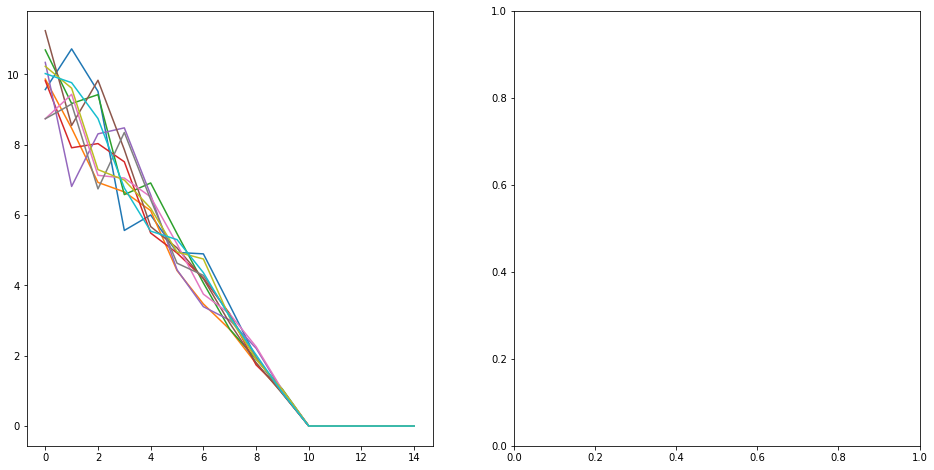

In [77]:
def gen_C(self):
    return random.normal(*uniform_to_normal((0.7, 1.3), pmsigma=3))

popsize=10
linpop = Population(popsize, title='linear w multiplicative error', symptomfunctiontype='linear', gen_C=gen_C)
exppop = Population(popsize, title='exponential w multiplicative error', symptomfunctiontype='exponential', gen_C=gen_C)

fig, axes = plt.subplots(ncols=2, figsize=plt.figaspect(1/2.0)*2)
ndays = 15
linpop.plot(axes[0], ndays=ndays)
exppop.plot(axes[1], ndays=ndays)
plt.show()

Intersting to note: the heterostatic error seems less pronounced for exponential symptoms.
This is likely due to its large slope early on, as an increase of the same amount which is about -1 days for the linear will seem like much less time difference for exponential. 
The opposite is true later on, when the exponential curve is slower than the linear one.